## OvR / OvO
* Internally OvO, but can generate out of that a [decision function of OvR](https://github.com/scikit-learn/scikit-learn/blob/a8cd4f4c80357bf124e9c30f8488a406d06db21c/sklearn/svm/base.py#L531-L549)


## Calculating Probs
* [Binary](http://www.cs.colorado.edu/~mozer/Teaching/syllabi/6622/papers/Platt1999.pdf)
* [Multi](https://www.csie.ntu.edu.tw/~cjlin/papers/svmprob/svmprob.pdf)
* And the full [`libsim`](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf) details.
* It seems that finding the probs to each `x` require solving optimization problem with constrains using iterative algorithm(!) - > This is not differentiable
* In `SVC`: `probA_` and `probB_`

### What can we do?
Train one Dense layer with softmat and categorial cross entropy on top of the SVM decision function values.

In [1]:
import numpy as np
import matplotlib.pylab as plt

plt.ion()

In [2]:
import sys
sys.path.append('../../data')
from corpus import load_corpus
data = load_corpus('weebit')

X_train = data['X_train']
y_train = data['y_train']
y_train_onehot = data['y_train_onehot']
X_test = data['X_test']
y_test = data['y_test']
y_test_onehot = data['y_test_onehot']

FEATURES_GROUPS = {'POS_DENSITY': ['feature_' + name for name in ['num_comma', 'nouns', 'propernouns', 'pronouns', 'conj', 'adj', 'ver', 'interj', 'adverbs', 'modals', 'perpro' , 'whpro', 'numfuncwords', 'numdet', 'numvb' , 'numvbd', 'numvbg', 'numvbn', 'numvbp']],
                  'READABILITY_SCORES': [name for name in X_train.columns if name.startswith('feature_rs_')],
                 }
FEATURES = FEATURES_GROUPS['POS_DENSITY'] + FEATURES_GROUPS['READABILITY_SCORES']


X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

Using TensorFlow backend.


In [3]:
from sklearn.metrics import accuracy_score

def threshold_socre(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)

def calc_scores(y_true, y_pred_probs):
    y_pred_avg = (y_pred_probs * np.arange(5)).sum(axis=1)
    y_pred_avg_classes = y_pred_avg.round().clip(0, 4).astype(int)
    return {'accuracy': accuracy_score(y_true, y_pred_avg_classes),
            'threshold': threshold_socre(y_true, y_pred_avg_classes)}

In [4]:
from sklearn.svm import SVC

model_ovo = SVC(kernel='rbf', C=1, probability=True, decision_function_shape='ovo')
model_ovo.fit(X_train, y_train)

y_pred_probs = model_ovo.predict_proba(X_test)
calc_scores(y_test, y_pred_probs)

# accuracy 0.608991
# threshold 0.922282

{'accuracy': 0.6112637362637363, 'threshold': 0.9244505494505495}

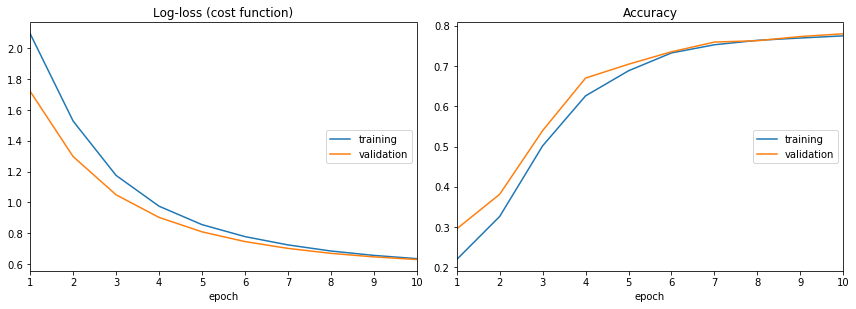

{'accuracy': 0.5796703296703297, 'threshold': 0.9244505494505495}

In [5]:
from keras.models import Sequential
from keras.layers import Dense

from livelossplot import PlotLossesKeras


prob_calculator_ovo = Sequential()
prob_calculator_ovo.add(Dense(5, input_dim=10, activation='softmax'))


X_dist_train = model_ovo.decision_function(X_train)

prob_calculator_ovo.compile(optimizer='rmsprop',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

prob_calculator_ovo.fit(X_dist_train, y_train_onehot, epochs=10, validation_split=0.1,
                    callbacks=[PlotLossesKeras()],
                    verbose=0)

X_dist_test = model_ovo.decision_function(X_test)
y_pred_probs = prob_calculator_ovo.predict_proba(X_dist_test)
calc_scores(y_test, y_pred_probs)

In [6]:
from sklearn.multiclass import OneVsRestClassifier

model_ovr = OneVsRestClassifier(SVC(kernel='rbf', C=1, probability=True, verbose=True))

model_ovr.fit(X_train, y_train)

y_pred = model_ovr.predict(X_test)
y_pred_probs = model_ovr.predict_proba(X_test)
calc_scores(y_test, y_pred_probs)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

{'accuracy': 0.5357142857142857, 'threshold': 0.9093406593406593}

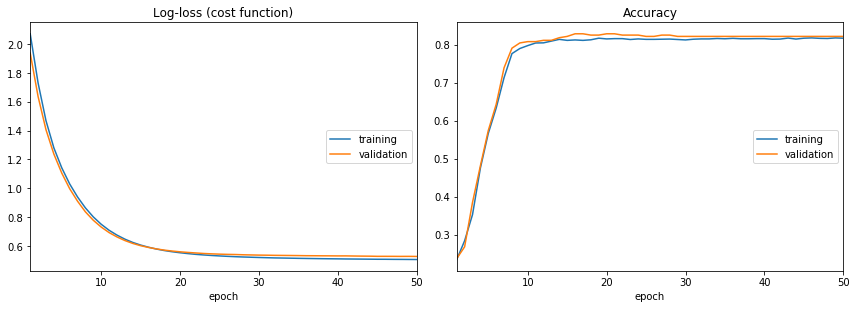

{'accuracy': 0.6304945054945055, 'threshold': 0.9217032967032966}

In [7]:
from keras.models import Sequential
from keras.layers import Dense

from livelossplot import PlotLossesKeras


prob_calculator_ovr = Sequential()
prob_calculator_ovr.add(Dense(5, input_dim=5, activation='softmax'))


X_dist_train = model_ovr.decision_function(X_train)

prob_calculator_ovr.compile(optimizer='rmsprop',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

prob_calculator_ovr.fit(X_dist_train, y_train_onehot, epochs=50, validation_split=0.1,
                    callbacks=[PlotLossesKeras()],
                    verbose=0)

X_dist_test = model_ovr.decision_function(X_test)
y_pred_probs = prob_calculator_ovr.predict_proba(X_dist_test)
calc_scores(y_test, y_pred_probs)

In [8]:
W_prob_array, b_prob_array = prob_calculator_ovr.get_weights()

In [9]:
# numpy version

from numpy.linalg import norm

def rbf(x1, x2, gamma):
    return np.exp(-gamma * norm(x1-x2, axis=1)**2)

def decision_funcion(single_model, x):
    return ((single_model.dual_coef_
             @ rbf(single_model.support_vectors_, x[None, :], single_model._gamma))
            + single_model.intercept_)

def generate_X_kernel_transformed(model, X):
    kernel_transformed_X = []
    for _, x in X_test.iterrows():
        kernel_transformed_X.append([
            decision_funcion(single_model, x)[0] for single_model in model.estimators_
        ])
    return np.array(kernel_transformed_X)

# test my decision function

for estimator in model_ovr.estimators_:
    for _, x in X_test.iterrows():
        np.testing.assert_almost_equal(decision_funcion(estimator, x), estimator.decision_function([x]))

In [10]:
X_kernel_transformed_test = generate_X_kernel_transformed(model_ovr, X_test)
y_pred_probs = prob_calculator_ovr.predict_proba(X_kernel_transformed_test)
y_pred_avg = (y_pred_probs * np.arange(5)).sum(axis=1)
calc_scores(y_test, y_pred_probs)
#{'accuracy': 0.625, 'threshold': 0.9244505494505495}

{'accuracy': 0.6304945054945055, 'threshold': 0.9217032967032966}

In [11]:
import tensorflow as tf

In [12]:
# extract parameters

parameters = []
for index, estimator in enumerate(model_ovr.estimators_):
    name_format = 'estimator_' + str(index)
    parameters.append({
        'dual_coef': tf.constant(estimator.dual_coef_.squeeze(), name=name_format+'_dual_coef', dtype=tf.float32),
        'gamma': tf.constant(estimator._gamma, name=name_format+'_gamma', dtype=tf.float32),
        'intercept': tf.constant(estimator.intercept_.squeeze(), name=name_format+'_intercept', dtype=tf.float32),
        'sv': tf.constant(estimator.support_vectors_, name=name_format+'_sv', dtype=tf.float32),
    })

In [13]:
def tf_rbf(x1, x2, gamma):
    return tf.exp(-gamma * tf.norm(x1-x2, axis=1)**2)

def tf_decision_funcion(single_parameters, x):
    rbf_dist = tf_rbf(single_parameters['sv'], x[None, :], single_parameters['gamma'])
    return (tf.tensordot(single_parameters['dual_coef'], rbf_dist, axes=1)
            + single_parameters['intercept'])

In [16]:
sess = tf.InteractiveSession()

with tf.name_scope('redability_score_graph') as scope:

    W_prob = tf.constant(W_prob_array.T, tf.float32, name='W_prob')
    b_prob = tf.constant(b_prob_array, tf.float32, name='b_prob')

    x = tf.placeholder(tf.float32, 26, name='input_features')

    svm_vals = []
    for index, single_parameters in enumerate(parameters):
        with tf.name_scope('decision_funcion_' + str(index)) as scope:
            svm_vals.append(tf_decision_funcion(single_parameters, x))

    svm_vals_tensor = tf.convert_to_tensor(svm_vals, name='svm_vals')

    with tf.name_scope('average_probs') as scope:
        logits = tf.tensordot(W_prob, svm_vals_tensor, 1) + b_prob

        probs = tf.nn.softmax(logits)

        readbility_score = tf.reduce_sum(tf.multiply(probs, np.arange(5)))

Testing

In [17]:
np.testing.assert_allclose(sess.run([svm_vals], feed_dict={x: X_test.iloc[200]})[0],
                                  X_kernel_transformed_test[200], rtol=1e-4)

np.testing.assert_allclose(sess.run([probs], feed_dict={x: X_test.iloc[200]})[0],
                                  y_pred_probs[200], rtol=1e-4)

np.testing.assert_allclose(sess.run([readbility_score], feed_dict={x: X_test.iloc[200]})[0],
                                  y_pred_avg[200], rtol=1e-4)

Save Model

In [24]:
init = tf.global_variables_initializer()
sess.run(init)

LOGDIR='readability_score_tensorflow'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)

tf.saved_model.simple_save(sess,
            LOGDIR + '/simple',
            inputs={'x': x},
            outputs={'readbility_score': readbility_score})

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'readability_score_tensorflow/simple/saved_model.pb'
